##### Copyright 2019 The TensorFlow Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [5]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf
import pytz
from gs_quant.timeseries.technicals import bollinger_bands, moving_average, smoothed_moving_average, relative_strength_index

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False

## The kibot nasdaq100 30min dataset

Purchased this dataset from kibot

$90	    NASDAQ 100 historical data, 30 minute interval

[data-format](http://www.kibot.com/Data_Format.aspx)

`Date, Time, Open, High, Low, Close, Volume`

In [6]:
data_path = 'data/kibot/nasdaq100-30min-adjusted'

In [7]:
assert(os.path.isdir(data_path))

In [8]:
columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

In [9]:
def kibot_datetimes(df):
    return (df['date'] + ' ' + df['time']).apply(pd.to_datetime)

In [10]:
def ticker_df(directory_path, filename):
    split_filename = filename.split('.')
    ticker = split_filename[0].lower()
    file_path = f'{directory_path}/{filename}'
    df = pd.read_csv(file_path, names=columns, index_col=False)
    df['datetime'] = kibot_datetimes(df)
    df = df.set_index(['datetime'])
    df = df.drop(['date', 'time'], axis=1)
    return ticker, df

In [11]:
tickers = ['tsla']

In [12]:
ticker_dfs = dict(
    ticker_df(data_path, filename)
    for filename in os.listdir(data_path)
    if any(ticker.upper() in filename for ticker in tickers)
)

This tutorial will just deal with **30min predictions**.

In [13]:
kibot_df = pd.concat(ticker_dfs.values(), axis=1, keys=ticker_dfs.keys())

In [14]:
kibot_df.index = kibot_df.index.map(pd.to_datetime).map(lambda dt: pd.Timestamp.tz_localize(dt, pytz.utc))

In [15]:
kibot_df.columns[:20]

MultiIndex([('tsla',   'open'),
            ('tsla',   'high'),
            ('tsla',    'low'),
            ('tsla',  'close'),
            ('tsla', 'volume')],
           )

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

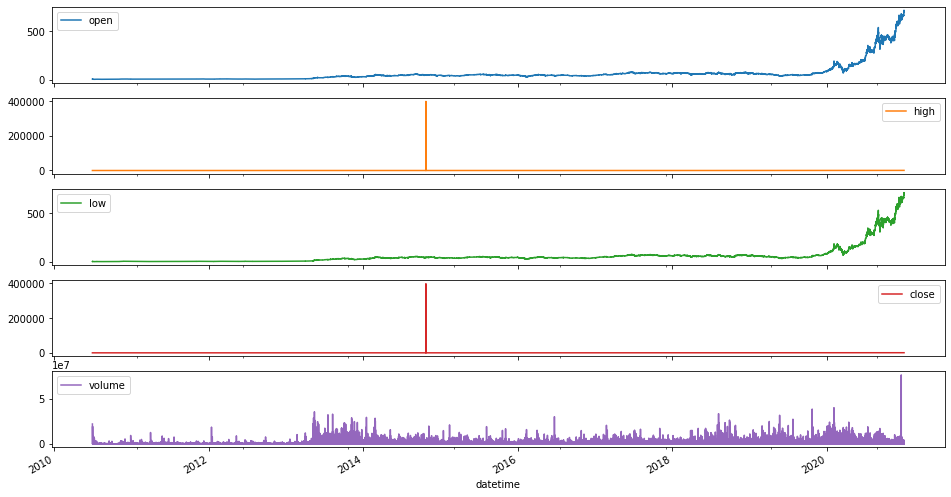

In [16]:
kibot_df['tsla'].plot(subplots=True)

Some of these nasdaq 100 tickers have existed longer than others. Important when deciding what the first datapoint should be.

Add yfinance data

In [17]:
period = '60d' # yfinance max period for 30 min data
interval = '30m'

In [18]:
yfinance_df = yf.download(  # or pdr.get_data_yahoo(...
    # tickers list or string as well
    tickers = tickers,

    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    period = period,

    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d')
    interval = interval,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by = 'ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost = False,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads = 4,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy = None
)

[*********************100%***********************]  1 of 1 completed


In [19]:
yfinance_df.index = yfinance_df.index.map(pd.to_datetime).map(lambda dt: pd.Timestamp.tz_convert(dt, pytz.utc))

In [20]:
yfinance_df.columns = [f'tsla_{column.lower()}' for column in yfinance_df.columns]

In [21]:
last_kibot_date = max(kibot_df.index)

In [22]:
trimmed_yfinance_df = yfinance_df[yfinance_df.index > last_kibot_date]

In [23]:
trimmed_yfinance_df.head()

,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume
Datetime,,,,,
2020-12-31 20:00:00+00:00,702.239990,705.250000,698.000000,698.000000,3853153
2020-12-31 20:30:00+00:00,698.203186,706.899902,697.690002,705.210022,4105876
2021-01-04 14:30:00+00:00,719.460022,742.799988,717.189514,738.549988,11617295
2021-01-04 15:00:00+00:00,738.950012,743.000000,733.500000,740.030029,4562141
2021-01-04 15:30:00+00:00,740.000000,744.489929,730.770020,731.200073,4511525


One thing to notice is that we are working with a multiindex dataframe, we can flatten this to make it easier to work with.


In [24]:
def flatten_multi_index_df(df):
    if type(df.columns) is not pd.core.indexes.multi.MultiIndex:
        raise Exception('provided dataframe does not have multiindex columns')
    tuple_column_flattener = lambda tup: f'{tup[0].lower()}_{tup[1].lower()}'
    flattened_columns = df.columns.to_flat_index().map(tuple_column_flattener)
    flattened_df = df.copy() # I don't like mutating the original dataframe, yes this more memory intensive
    flattened_df.columns = flattened_columns
    return flattened_df

In [25]:
df = pd.concat([flatten_multi_index_df(kibot_df), trimmed_yfinance_df])

In [26]:
df.head()

,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume
2010-06-29 11:00:00+00:00,3.80,3.800,3.61,3.640,22147995
2010-06-29 11:30:00+00:00,3.64,3.640,3.51,3.620,19526455
2010-06-29 12:00:00+00:00,3.62,3.682,3.61,3.674,6297820
2010-06-29 12:30:00+00:00,3.67,3.700,3.65,3.670,3690030
2010-06-29 13:00:00+00:00,3.68,3.760,3.66,3.756,2933845


In [27]:
df.tail()

,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume
2021-01-13 18:30:00+00:00,837.950012,844.000000,836.550110,844.000000,1224988
2021-01-13 19:00:00+00:00,843.951782,855.450012,842.774109,853.849976,3181366
2021-01-13 19:30:00+00:00,854.030029,855.729980,849.510010,855.630005,2168620
2021-01-13 20:00:00+00:00,855.501770,858.000000,851.130127,851.441101,2042932
2021-01-13 20:30:00+00:00,851.386414,855.828125,849.750000,854.289978,2297691


### Inspect and cleanup

Next look at the statistics of the dataset:

In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tsla_open,69015.0,71.007459,1.040178e+02,3.040,34.540,47.1100,6.353000e+01,8.824900e+02
tsla_high,69015.0,77.069572,1.519875e+03,3.080,34.700,47.2660,6.371380e+01,3.984072e+05
tsla_low,69015.0,70.709587,1.034601e+02,2.996,34.379,47.0000,6.340000e+01,8.750500e+02
tsla_close,69015.0,76.783687,1.519840e+03,3.044,34.550,47.1124,6.353000e+01,3.984072e+05
tsla_volume,69015.0,999966.374527,1.914681e+06,132.000,13000.000,223740.0000,1.233108e+06,7.639698e+07


We get 14 30 minute ticks per day, important for windowing purposes

In [29]:
TICKS_PER_DAY = 14

In [30]:
df.dtypes

tsla_open      float64
tsla_high      float64
tsla_low       float64
tsla_close     float64
tsla_volume      int64
dtype: object

array([<AxesSubplot:>], dtype=object)

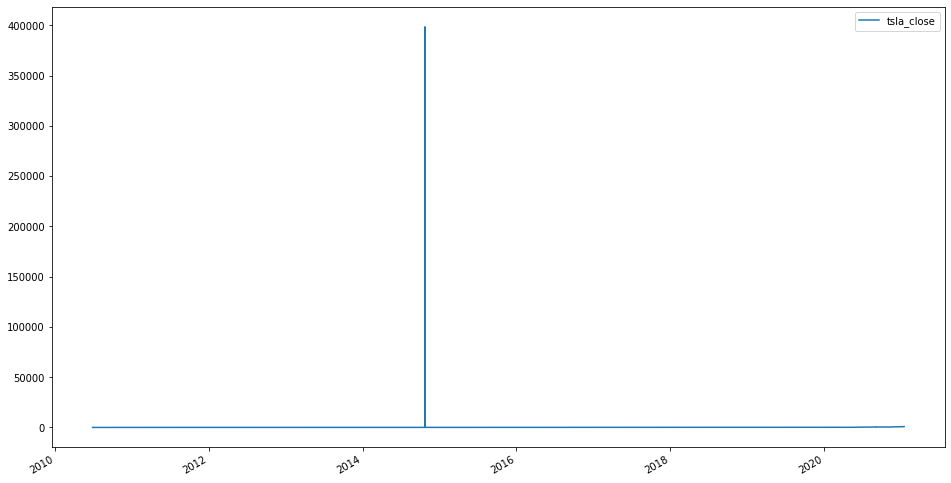

In [31]:
df[['tsla_close']].plot(subplots=True)

Since I don't want to deal with backfilling, I just choose the ticker I want to work with. I can make a model per ticker. I can make a model that has all tickers in one.

In [32]:
first_date_ticker = 'tsla'

In [33]:
first_valid_index = df[f'{first_date_ticker}_close'].first_valid_index()

In [34]:
first_valid_index

Timestamp('2010-06-29 11:00:00+0000', tz='UTC')

In [35]:
df = df[first_valid_index:]
df = df.dropna(axis=0)
print(df.columns)

Index(['tsla_open', 'tsla_high', 'tsla_low', 'tsla_close', 'tsla_volume'], dtype='object')


array([<AxesSubplot:>], dtype=object)

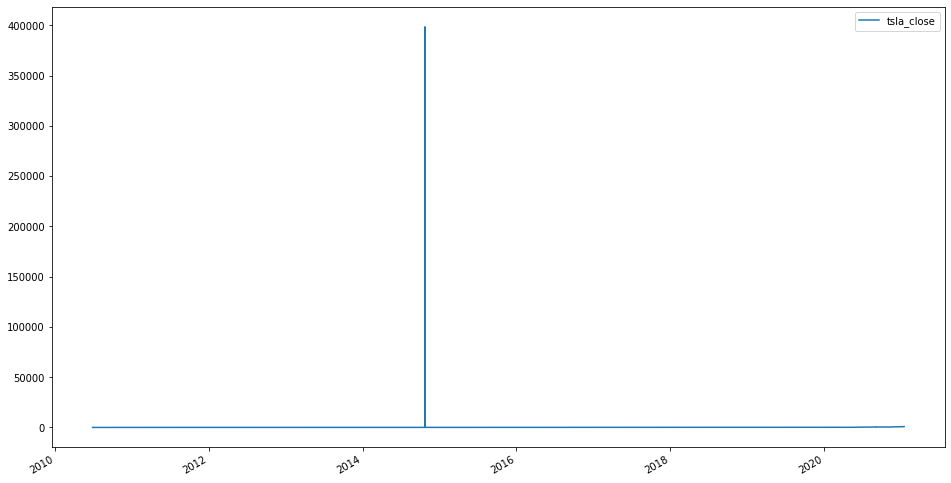

In [36]:
df[[f'{ticker}_close' for ticker in tickers]].plot(subplots=True)

The `tsla` data has an outlier... I will just drop the bad row by datetime

In [37]:
drop_indices = df[df['tsla_close'] > 1000].index

In [38]:
df = df.drop(drop_indices)

Now that outlier should be gone.

array([<AxesSubplot:>], dtype=object)

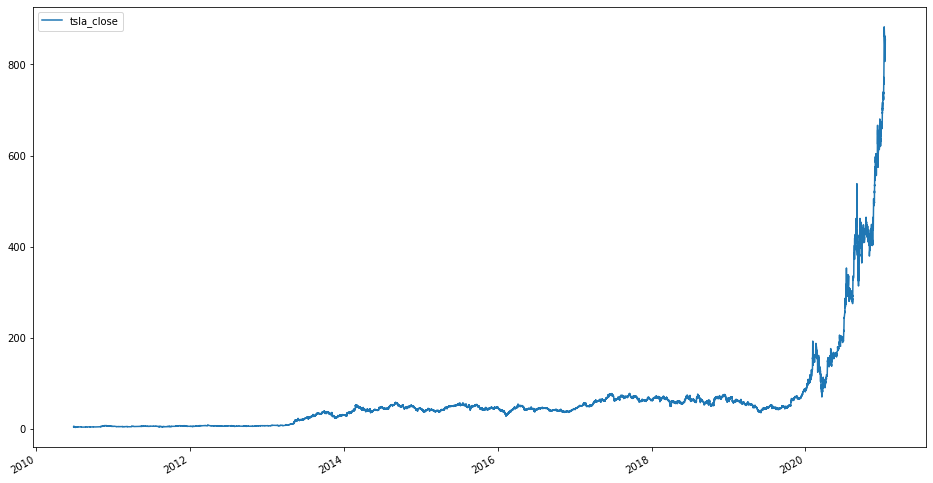

In [39]:
df[[f'{ticker}_close' for ticker in tickers]].plot(subplots=True)

In [40]:
df.head()

,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume
2010-06-29 11:00:00+00:00,3.80,3.800,3.61,3.640,22147995
2010-06-29 11:30:00+00:00,3.64,3.640,3.51,3.620,19526455
2010-06-29 12:00:00+00:00,3.62,3.682,3.61,3.674,6297820
2010-06-29 12:30:00+00:00,3.67,3.700,3.65,3.670,3690030
2010-06-29 13:00:00+00:00,3.68,3.760,3.66,3.756,2933845


In [41]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tsla_open,69014.0,71.007805,1.040185e+02,3.040,34.5400,47.1100,6.353000e+01,8.824900e+02
tsla_high,69014.0,71.297843,1.045563e+02,3.080,34.7000,47.2630,6.371150e+01,8.844900e+02
tsla_low,69014.0,70.709930,1.034608e+02,2.996,34.3745,47.0000,6.340000e+01,8.750500e+02
tsla_close,69014.0,71.011954,1.040407e+02,3.044,34.5500,47.1112,6.353000e+01,8.824500e+02
tsla_volume,69014.0,999980.706494,1.914691e+06,132.000,13000.0000,223740.0000,1.233116e+06,7.639698e+07


In [42]:
assert not df.isna().any(axis=0).any()

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [43]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp))
index_timestamp_seconds[:5]

array([1.2778092e+09, 1.2778110e+09, 1.2778128e+09, 1.2778146e+09,
       1.2778164e+09])

In [44]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

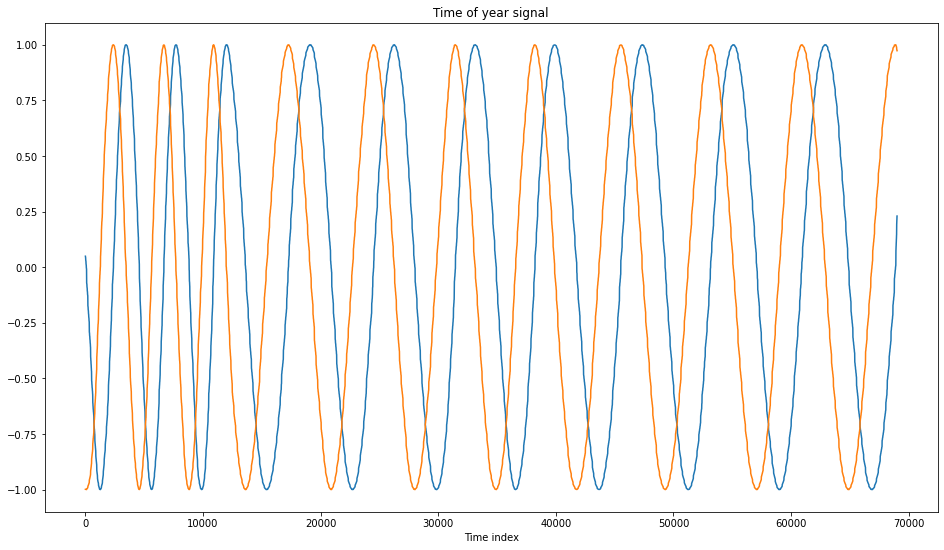

In [45]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

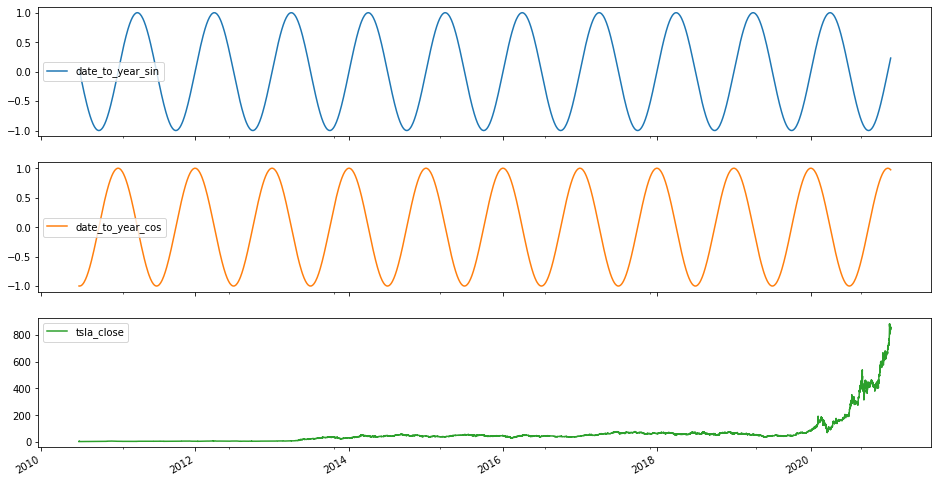

In [46]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df[['date_to_year_sin', 'date_to_year_cos', 'tsla_close']].plot(subplots=True)

#### Indicators

In [47]:
single_value_indicator_dicts = [
    {
        f'{ticker}_{indicator_feature}_moving_average': moving_average(df[f'{ticker}_{indicator_feature}'], TICKS_PER_DAY),
        f'{ticker}_{indicator_feature}_smoothed_moving_average': smoothed_moving_average(df[f'{ticker}_{indicator_feature}'], TICKS_PER_DAY),
        f'{ticker}_{indicator_feature}_relative_strength_index': relative_strength_index(df[f'{ticker}_{indicator_feature}'], TICKS_PER_DAY)       
    }
    for ticker in tickers
    for indicator_feature in ['close']
]

In [48]:
single_value_indicator_df = pd.DataFrame({
    feat: vals
    for multi_dict in single_value_indicator_dicts
    for (feat, vals) in multi_dict.items()
})

In [49]:
single_value_indicator_df.head()

,tsla_close_moving_average,tsla_close_smoothed_moving_average,tsla_close_relative_strength_index
2010-06-29 18:00:00+00:00,4.290879,4.290879,NaN
2010-06-29 18:30:00+00:00,4.377307,4.329387,81.875659
2010-06-29 19:00:00+00:00,4.457736,4.363002,80.505300
2010-06-29 19:30:00+00:00,4.538450,4.394217,80.505300
2010-06-30 06:00:00+00:00,4.628021,4.438201,82.837318


In [50]:
single_value_indicator_df.index

DatetimeIndex(['2010-06-29 18:00:00+00:00', '2010-06-29 18:30:00+00:00',
               '2010-06-29 19:00:00+00:00', '2010-06-29 19:30:00+00:00',
               '2010-06-30 06:00:00+00:00', '2010-06-30 06:30:00+00:00',
               '2010-06-30 07:00:00+00:00', '2010-06-30 07:30:00+00:00',
               '2010-06-30 08:00:00+00:00', '2010-06-30 08:30:00+00:00',
               ...
               '2021-01-13 16:00:00+00:00', '2021-01-13 16:30:00+00:00',
               '2021-01-13 17:00:00+00:00', '2021-01-13 17:30:00+00:00',
               '2021-01-13 18:00:00+00:00', '2021-01-13 18:30:00+00:00',
               '2021-01-13 19:00:00+00:00', '2021-01-13 19:30:00+00:00',
               '2021-01-13 20:00:00+00:00', '2021-01-13 20:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=69000, freq=None)

In [51]:
single_value_indicator_df[single_value_indicator_df.isna().any(axis=1)]

,tsla_close_moving_average,tsla_close_smoothed_moving_average,tsla_close_relative_strength_index
2010-06-29 18:00:00+00:00,4.290879,4.290879,NaN


In [52]:
single_value_indicator_df = single_value_indicator_df.dropna(axis=1)

In [53]:
assert not single_value_indicator_df.isna().any(axis=1).any()

In [54]:
multi_value_indicator_dicts = [
    {
        f'{ticker}_{indicator_feature}_bollinger_bands': bollinger_bands(df[f'{ticker}_{indicator_feature}'], TICKS_PER_DAY),     
    }
    for ticker in tickers
    for indicator_feature in ['close']
]

In [55]:
flattened_multi_value_indicator_df = pd.DataFrame({
    f'{feat}_{col}': vals[col]
    for multi_dict in multi_value_indicator_dicts
    for (feat, vals) in multi_dict.items()
    for col in vals
})

In [56]:
flattened_multi_value_indicator_df.head()

,tsla_close_bollinger_bands_0,tsla_close_bollinger_bands_1
2010-06-29 18:00:00+00:00,3.288964,5.292793
2010-06-29 18:30:00+00:00,3.416786,5.337828
2010-06-29 19:00:00+00:00,3.564700,5.350771
2010-06-29 19:30:00+00:00,3.754510,5.322390
2010-06-30 06:00:00+00:00,3.949758,5.306285


In [57]:
flattened_multi_value_indicator_df.index

DatetimeIndex(['2010-06-29 18:00:00+00:00', '2010-06-29 18:30:00+00:00',
               '2010-06-29 19:00:00+00:00', '2010-06-29 19:30:00+00:00',
               '2010-06-30 06:00:00+00:00', '2010-06-30 06:30:00+00:00',
               '2010-06-30 07:00:00+00:00', '2010-06-30 07:30:00+00:00',
               '2010-06-30 08:00:00+00:00', '2010-06-30 08:30:00+00:00',
               ...
               '2021-01-13 16:00:00+00:00', '2021-01-13 16:30:00+00:00',
               '2021-01-13 17:00:00+00:00', '2021-01-13 17:30:00+00:00',
               '2021-01-13 18:00:00+00:00', '2021-01-13 18:30:00+00:00',
               '2021-01-13 19:00:00+00:00', '2021-01-13 19:30:00+00:00',
               '2021-01-13 20:00:00+00:00', '2021-01-13 20:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=69000, freq=None)

In [58]:
assert not flattened_multi_value_indicator_df.isna().any(axis=1).any()

In [59]:
indicator_df = single_value_indicator_df.join(flattened_multi_value_indicator_df, how='outer')

In [60]:
indicator_df.head()

,tsla_close_moving_average,tsla_close_smoothed_moving_average,tsla_close_bollinger_bands_0,tsla_close_bollinger_bands_1
2010-06-29 18:00:00+00:00,4.290879,4.290879,3.288964,5.292793
2010-06-29 18:30:00+00:00,4.377307,4.329387,3.416786,5.337828
2010-06-29 19:00:00+00:00,4.457736,4.363002,3.564700,5.350771
2010-06-29 19:30:00+00:00,4.538450,4.394217,3.754510,5.322390
2010-06-30 06:00:00+00:00,4.628021,4.438201,3.949758,5.306285


In [61]:
indicator_df.tail()

,tsla_close_moving_average,tsla_close_smoothed_moving_average,tsla_close_bollinger_bands_0,tsla_close_bollinger_bands_1
2021-01-13 18:30:00+00:00,845.764945,843.989408,831.859507,859.670383
2021-01-13 19:00:00+00:00,845.628514,844.693734,832.113511,859.143517
2021-01-13 19:30:00+00:00,845.935665,845.474897,831.686961,860.184368
2021-01-13 20:00:00+00:00,845.752886,845.901054,831.889358,859.616415
2021-01-13 20:30:00+00:00,845.447662,846.500263,832.652021,858.243304


In [62]:
indicator_df.isna().any(axis=1)

2010-06-29 18:00:00+00:00    False
2010-06-29 18:30:00+00:00    False
2010-06-29 19:00:00+00:00    False
2010-06-29 19:30:00+00:00    False
2010-06-30 06:00:00+00:00    False
                             ...  
2021-01-13 18:30:00+00:00    False
2021-01-13 19:00:00+00:00    False
2021-01-13 19:30:00+00:00    False
2021-01-13 20:00:00+00:00    False
2021-01-13 20:30:00+00:00    False
Length: 69000, dtype: bool

In [63]:
df = indicator_df.join(df, how='inner')

In [64]:
df.head()

,tsla_close_moving_average,tsla_close_smoothed_moving_average,tsla_close_bollinger_bands_0,tsla_close_bollinger_bands_1,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,date_to_year_sin,date_to_year_cos
2010-06-29 18:00:00+00:00,4.290879,4.290879,3.288964,5.292793,4.75,4.83,4.75,4.80,33225,0.044218,-0.999022
2010-06-29 18:30:00+00:00,4.377307,4.329387,3.416786,5.337828,4.80,4.83,4.79,4.83,26630,0.043860,-0.999038
2010-06-29 19:00:00+00:00,4.457736,4.363002,3.564700,5.350771,4.83,4.83,4.80,4.80,14025,0.043502,-0.999053
2010-06-29 19:30:00+00:00,4.538450,4.394217,3.754510,5.322390,4.81,4.84,4.80,4.80,39120,0.043144,-0.999069
2010-06-30 06:00:00+00:00,4.628021,4.438201,3.949758,5.306285,5.01,5.01,5.01,5.01,7500,0.035624,-0.999365


In [65]:
df.tail()

,tsla_close_moving_average,tsla_close_smoothed_moving_average,tsla_close_bollinger_bands_0,tsla_close_bollinger_bands_1,tsla_open,tsla_high,tsla_low,tsla_close,tsla_volume,date_to_year_sin,date_to_year_cos
2021-01-13 18:30:00+00:00,845.764945,843.989408,831.859507,859.670383,837.950012,844.000000,836.550110,844.000000,1224988,0.228537,0.973535
2021-01-13 19:00:00+00:00,845.628514,844.693734,832.113511,859.143517,843.951782,855.450012,842.774109,853.849976,3181366,0.228886,0.973453
2021-01-13 19:30:00+00:00,845.935665,845.474897,831.686961,860.184368,854.030029,855.729980,849.510010,855.630005,2168620,0.229235,0.973371
2021-01-13 20:00:00+00:00,845.752886,845.901054,831.889358,859.616415,855.501770,858.000000,851.130127,851.441101,2042932,0.229583,0.973289
2021-01-13 20:30:00+00:00,845.447662,846.500263,832.652021,858.243304,851.386414,855.828125,849.750000,854.289978,2297691,0.229932,0.973207


In [66]:
output_path = f'data/kibot/nasdaq100-30min-adjusted-{"-".join(tickers)}.csv'
df.to_csv(output_path)

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [67]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [68]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors.

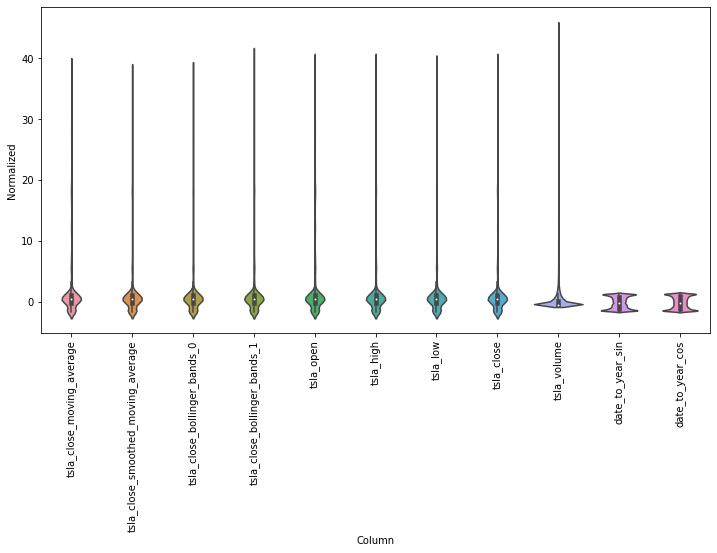

In [69]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [70]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [71]:
label_columns = ['tsla_close']

In [72]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=label_columns)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['tsla_close']

In [73]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=label_columns)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['tsla_close']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [74]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [75]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 11)
Inputs shape: (3, 6, 11)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['tsla_close']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [76]:
w2.example = example_inputs, example_labels

In [77]:
def plot(self, model=None, plot_col='tsla_close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [30m]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

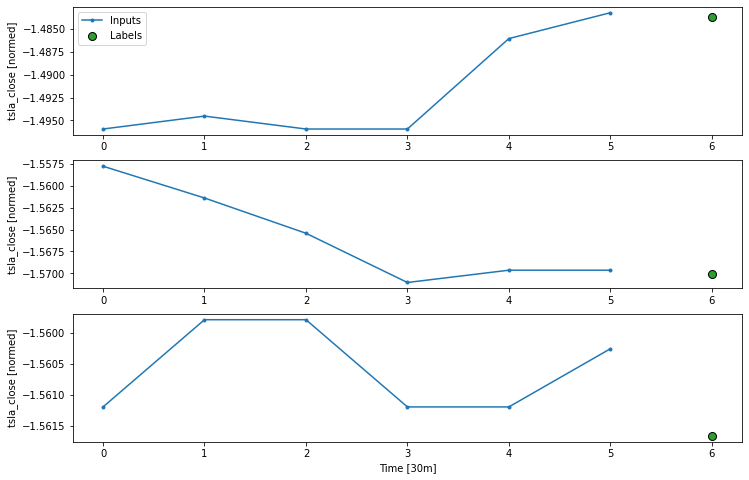

In [78]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `tsla_volume` column.

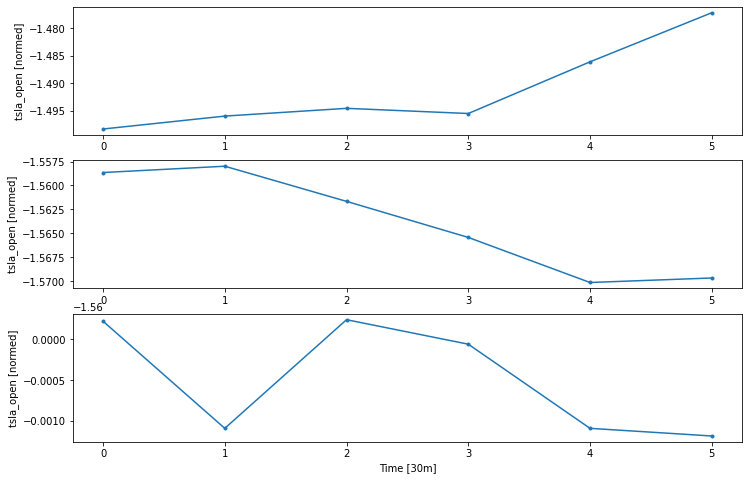

In [79]:
w2.plot(plot_col='tsla_open')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [80]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [81]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [82]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [83]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 11)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `tsla_close` value 1h into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [84]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['tsla_close']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [85]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 11)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [86]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [87]:
baseline = Baseline(label_index=column_indices['tsla_close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

432/432 [==============================] - 1s 1ms/step - loss: 5.3817e-04 - mean_absolute_error: 0.0113


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [88]:

wide_window = WindowGenerator(
    input_width=TICKS_PER_DAY, label_width=TICKS_PER_DAY, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['tsla_close']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [89]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 14, 11)
Output shape: (32, 14, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

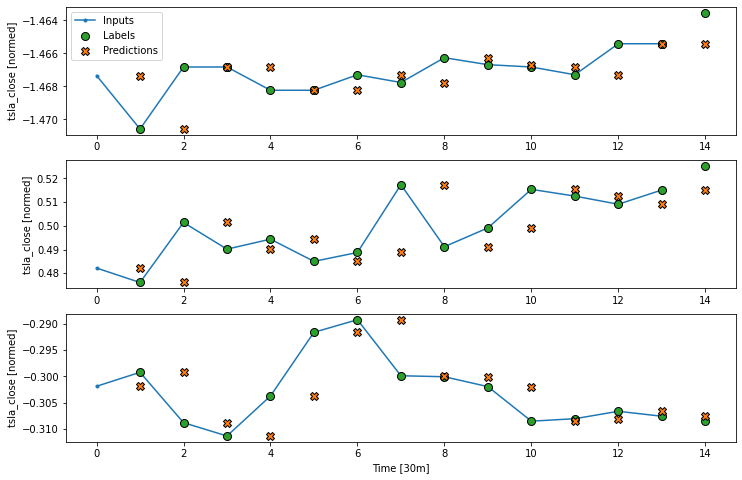

In [90]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explaination:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [91]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [92]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 11)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [93]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

Epoch 1/20
1510/1510 [==============================] - 2s 1ms/step - loss: 0.2615 - mean_absolute_error: 0.3147 - val_loss: 0.0069 - val_mean_absolute_error: 0.0435
Epoch 2/20
1510/1510 [==============================] - 2s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0183 - val_loss: 0.0050 - val_mean_absolute_error: 0.0330
Epoch 3/20
1510/1510 [==============================] - 2s 1ms/step - loss: 5.8739e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0042 - val_mean_absolute_error: 0.0309
Epoch 4/20
1510/1510 [==============================] - 2s 1ms/step - loss: 5.0464e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0034 - val_mean_absolute_error: 0.0275
Epoch 5/20
1510/1510 [==============================] - 2s 1ms/step - loss: 4.0068e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0023 - val_mean_absolute_error: 0.0243
Epoch 6/20
1510/1510 [==============================] - 2s 1ms/step - loss: 3.0421e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0018 - val_mean_absolute_er

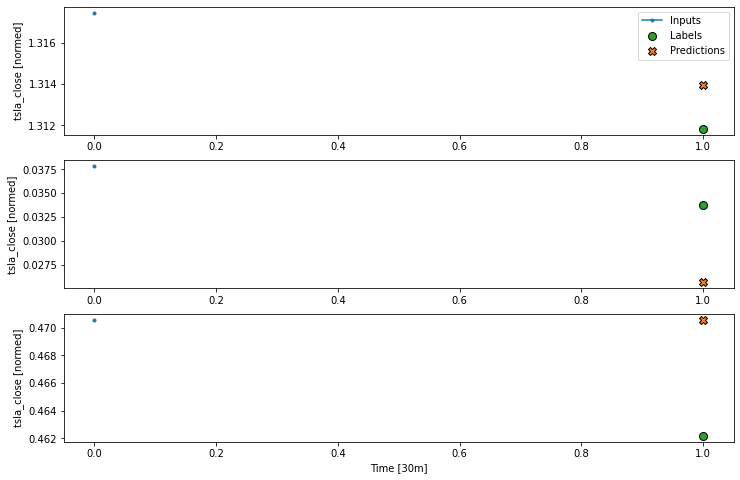

In [94]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(linear)

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [95]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 14, 11)
Output shape: (32, 14, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

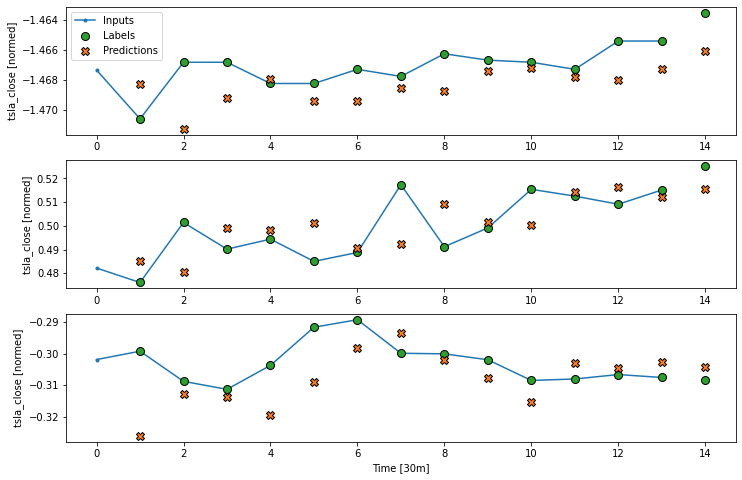

In [96]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

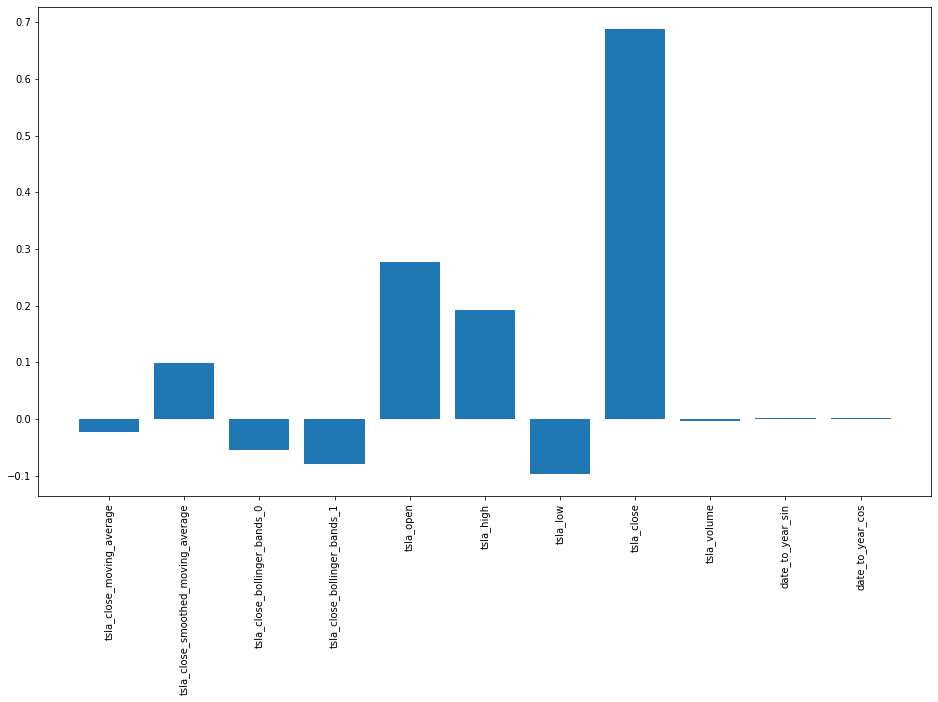

In [97]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `tsla_close`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [98]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1510/1510 [==============================] - 3s 1ms/step - loss: 0.0289 - mean_absolute_error: 0.0523 - val_loss: 0.0012 - val_mean_absolute_error: 0.0189
Epoch 2/20
1510/1510 [==============================] - 2s 1ms/step - loss: 2.9058e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0016 - val_mean_absolute_error: 0.0228
Epoch 3/20
432/432 [==============================] - 1s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0205


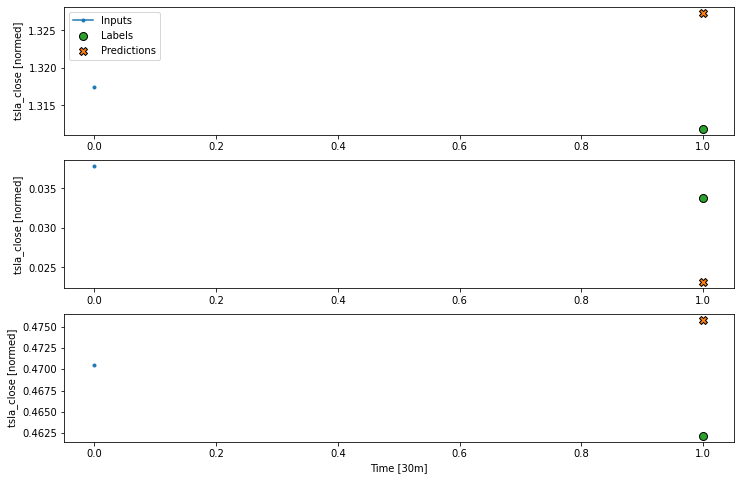

In [99]:
single_step_window.plot(dense)

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [100]:
CONV_WIDTH = TICKS_PER_DAY // 4
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['tsla_close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['tsla_close']

Text(0.5, 1.0, 'Given 3 30min ticks as input, predict 1 30min ticks into the future.')

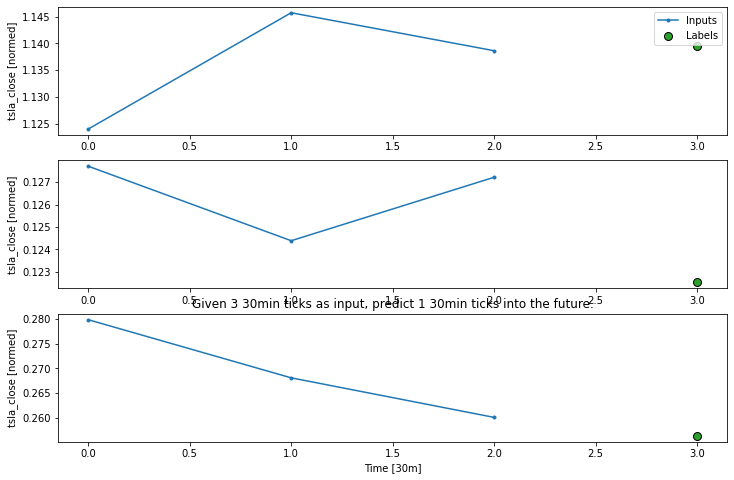

In [101]:
conv_window.plot()
plt.title(f"Given {CONV_WIDTH} 30min ticks as input, predict 1 30min ticks into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [102]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [103]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 11)
Output shape: (32, 1, 1)


In [104]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

432/432 [==============================] - 1s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0194


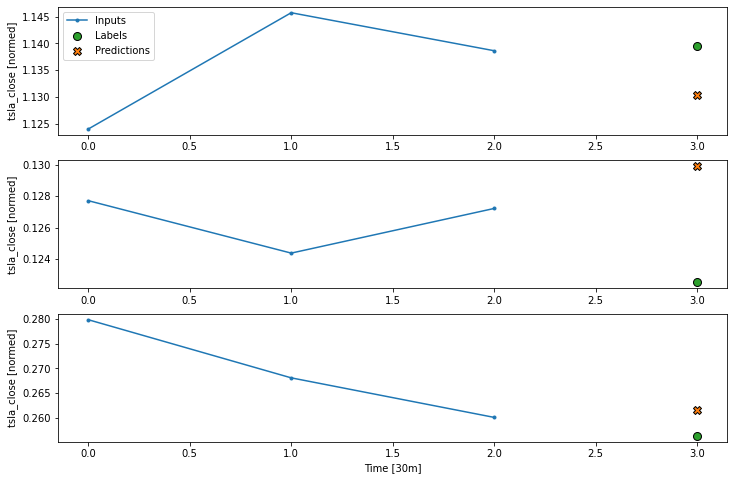

In [105]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [106]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 14, 11)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 33 but received input with shape (32, 154)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [107]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [108]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 11)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

432/432 [==============================] - 0s 1ms/step - loss: 0.0033 - mean_absolute_error: 0.0340


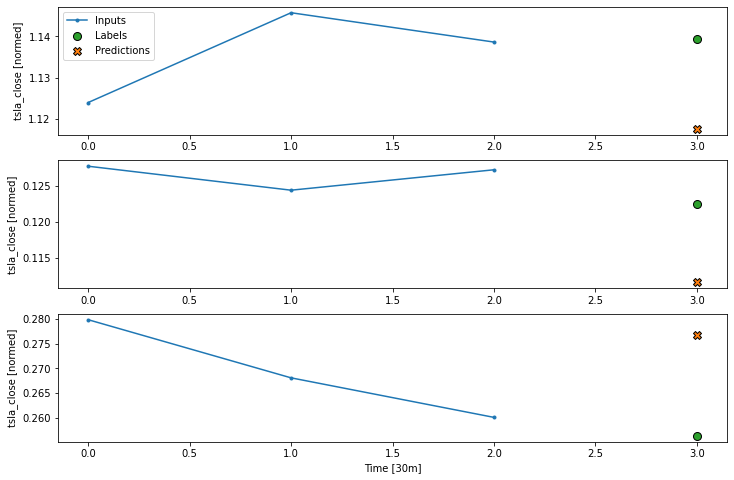

In [109]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_window.plot(conv_model)

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [110]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 14, 11)
Labels shape: (32, 14, 1)
Output shape: (32, 12, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [111]:
LABEL_WIDTH = TICKS_PER_DAY * 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['tsla_close'])

wide_conv_window

Total window size: 17
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Label column name(s): ['tsla_close']

In [112]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 16, 11)
Labels shape: (32, 14, 1)
Output shape: (32, 14, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

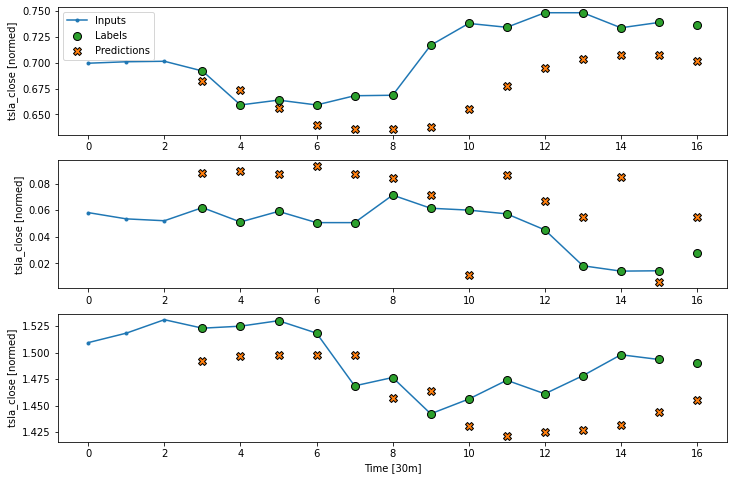

In [113]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [114]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 7h of data at a time. 7h is important because it is the number of rows yfinance provides per day. 7h is a day.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [115]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 14, 11)
Output shape: (32, 14, 1)


431/431 [==============================] - 1s 2ms/step - loss: 0.1201 - mean_absolute_error: 0.0828


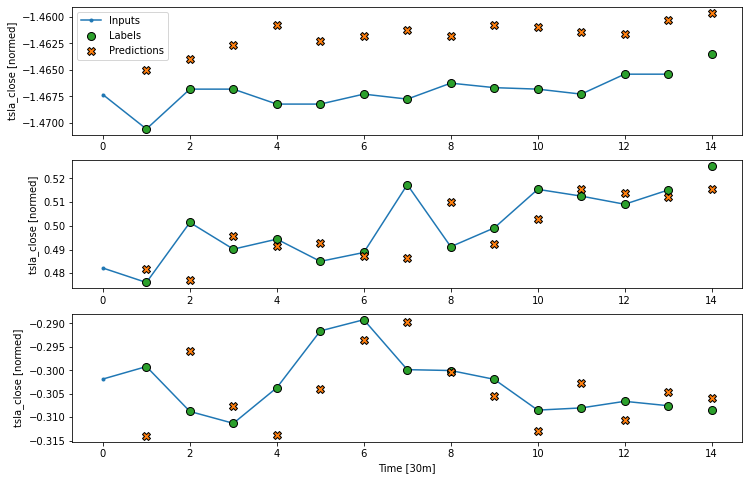

In [116]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

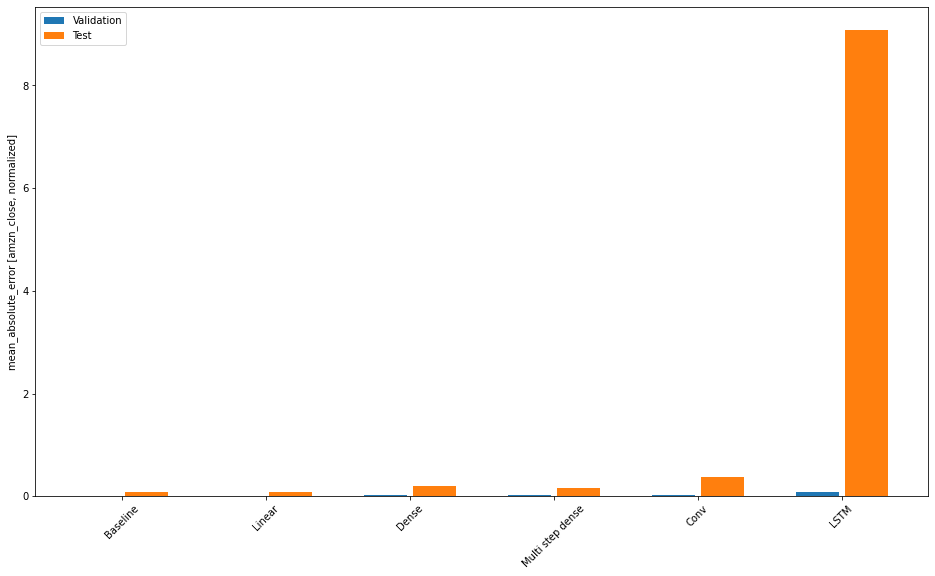

In [117]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [amzn_close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [118]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0808
Linear      : 0.0866
Dense       : 0.2059
Multi step dense: 0.1675
Conv        : 0.3690
LSTM        : 9.0737


### Multi-output models

The models so far all predicted a single output feature, `tsla_close`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [119]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=TICKS_PER_DAY, label_width=TICKS_PER_DAY, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 14, 11)
Labels shape (batch, time, features): (32, 14, 11)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [120]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

431/431 [==============================] - 0s 945us/step - loss: 0.1536 - mean_absolute_error: 0.0506


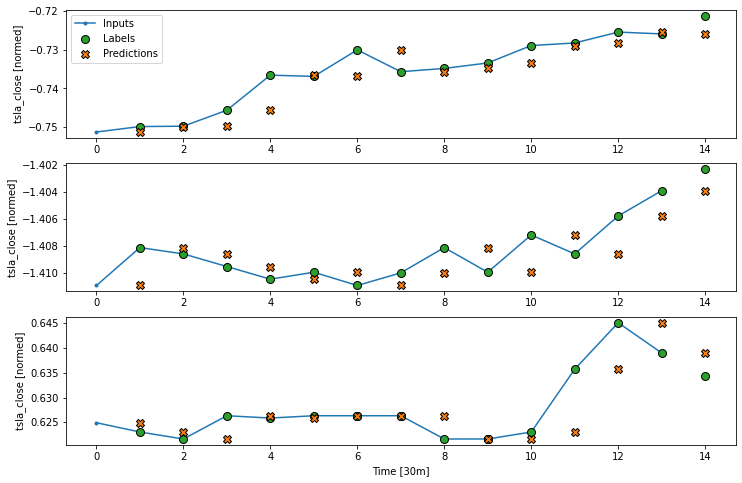

In [121]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)
wide_window.plot(baseline)

#### Dense

In [122]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

432/432 [==============================] - 0s 1ms/step - loss: 0.1255 - mean_absolute_error: 0.0601


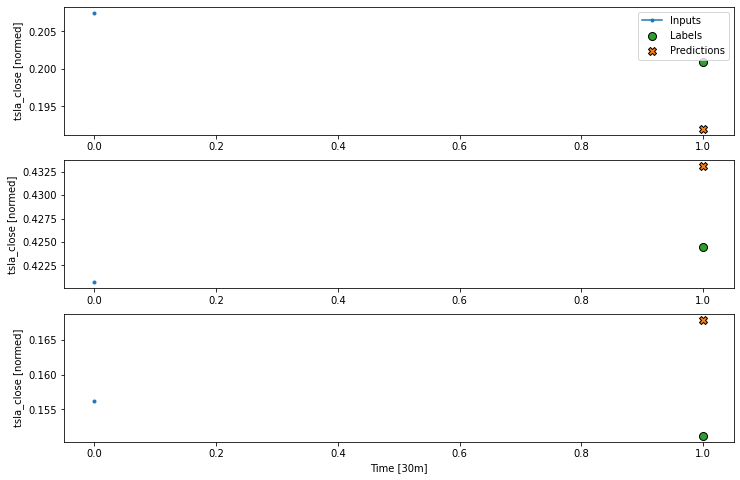

In [123]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(dense)

#### RNN


431/431 [==============================] - 1s 2ms/step - loss: 0.4137 - mean_absolute_error: 0.1824
CPU times: user 1min 55s, sys: 29 s, total: 2min 24s
Wall time: 45.1 s


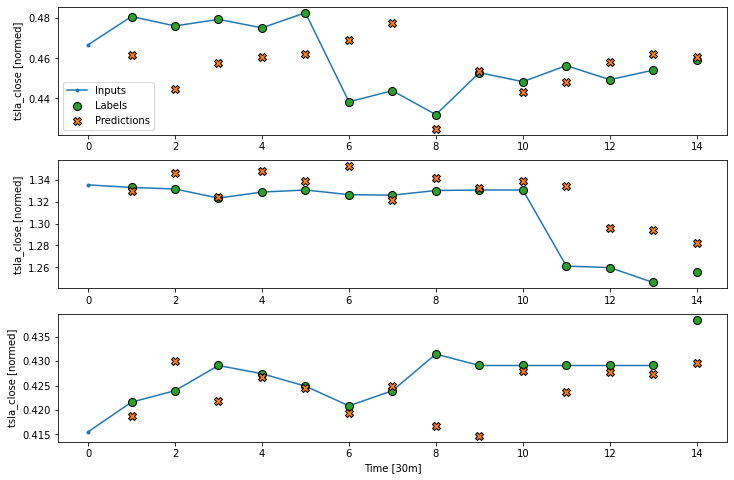

In [124]:
%%time
wide_window = WindowGenerator(
    input_width=TICKS_PER_DAY, label_width=TICKS_PER_DAY, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)

<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [125]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

431/431 [==============================] - 1s 2ms/step - loss: 0.1052 - mean_absolute_error: 0.0495
CPU times: user 3min 17s, sys: 49.2 s, total: 4min 6s
Wall time: 1min 15s


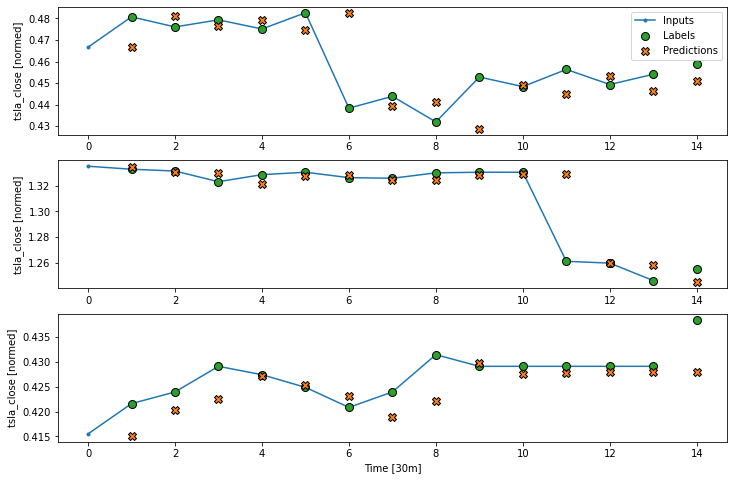

In [126]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
wide_window.plot(residual_lstm)

#### Performance

Here is the overall performance for these multi-output models.

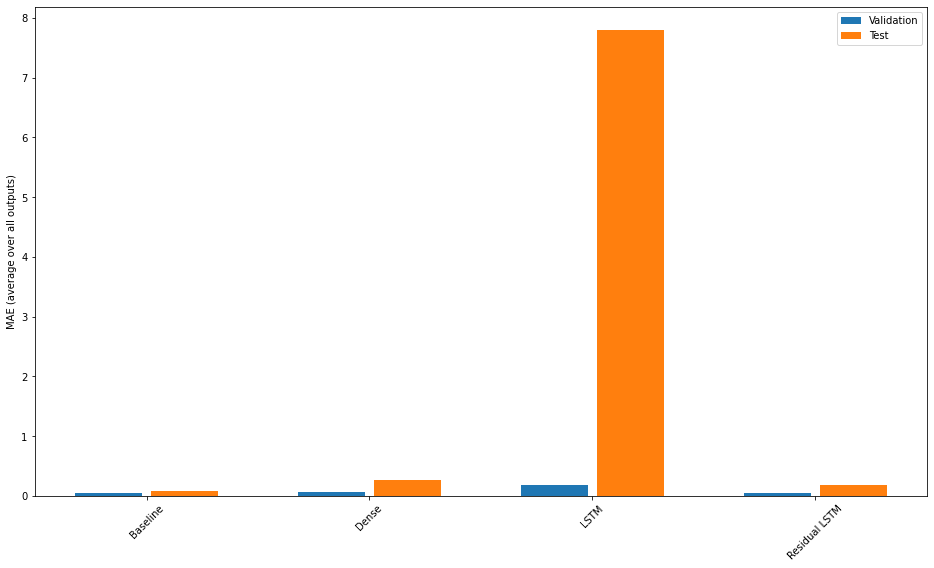

In [127]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [128]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0860
Dense          : 0.2694
LSTM           : 7.7962
Residual LSTM  : 0.1816


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 140
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Label indices: [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139]
Label column name(s): None

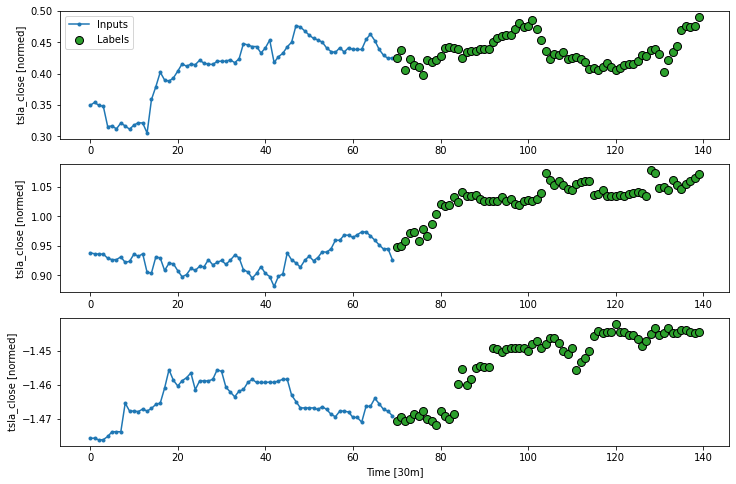

In [163]:
OUT_STEPS = TICKS_PER_DAY * 5
multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

427/427 [==============================] - 1s 1ms/step - loss: 0.3574 - mean_absolute_error: 0.1643


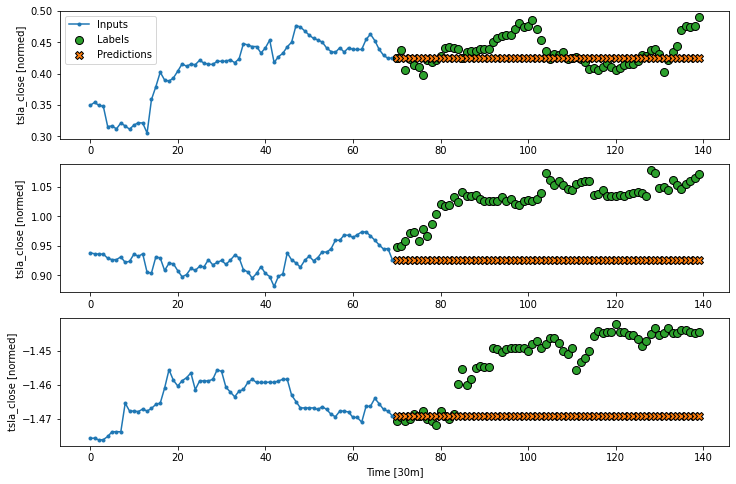

In [164]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

427/427 [==============================] - 1s 981us/step - loss: 0.3827 - mean_absolute_error: 0.2064


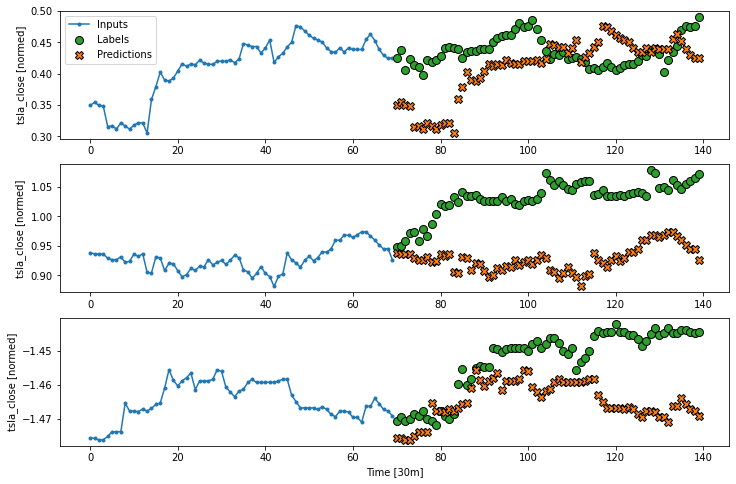

In [165]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

427/427 [==============================] - 1s 1ms/step - loss: 0.1973 - mean_absolute_error: 0.1344


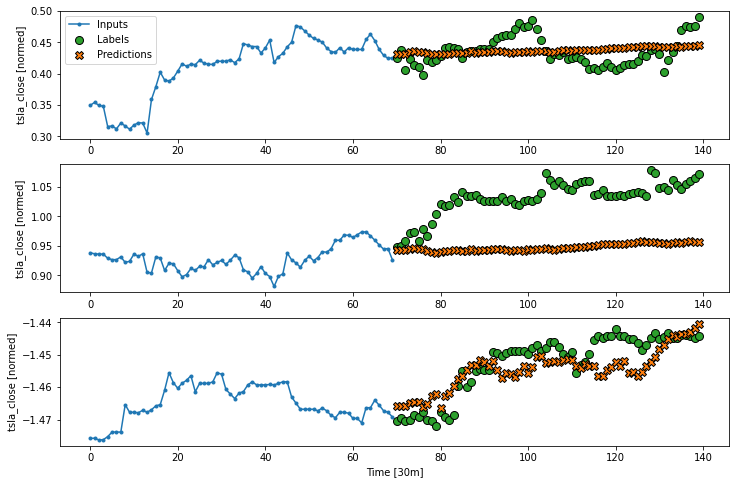

In [166]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

427/427 [==============================] - 1s 1ms/step - loss: 0.1960 - mean_absolute_error: 0.1627


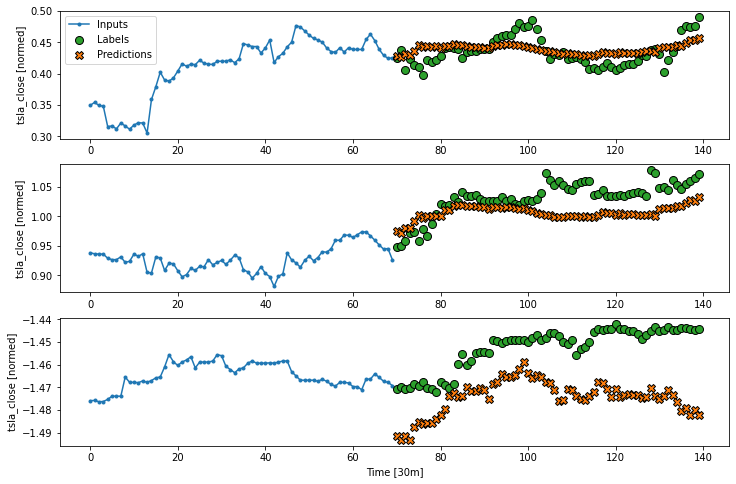

In [167]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

427/427 [==============================] - 1s 1ms/step - loss: 0.1845 - mean_absolute_error: 0.1754


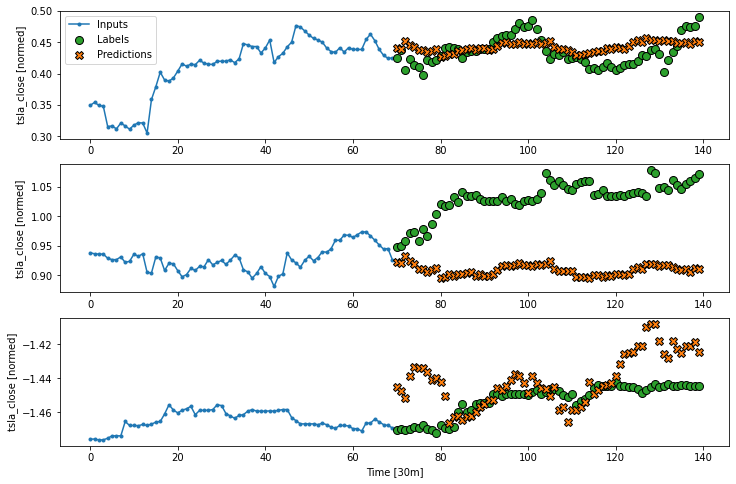

In [168]:
CONV_WIDTH = TICKS_PER_DAY
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


427/427 [==============================] - 1s 3ms/step - loss: 0.5169 - mean_absolute_error: 0.2387


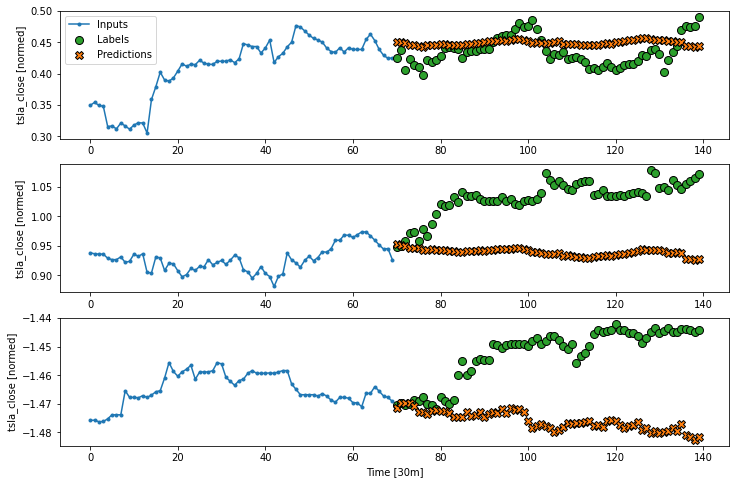

In [169]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence as a in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of single single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [170]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [171]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [172]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [173]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 11])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [174]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [175]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 70, 11)


Now train the model:

427/427 [==============================] - 2s 5ms/step - loss: 0.8019 - mean_absolute_error: 0.3352


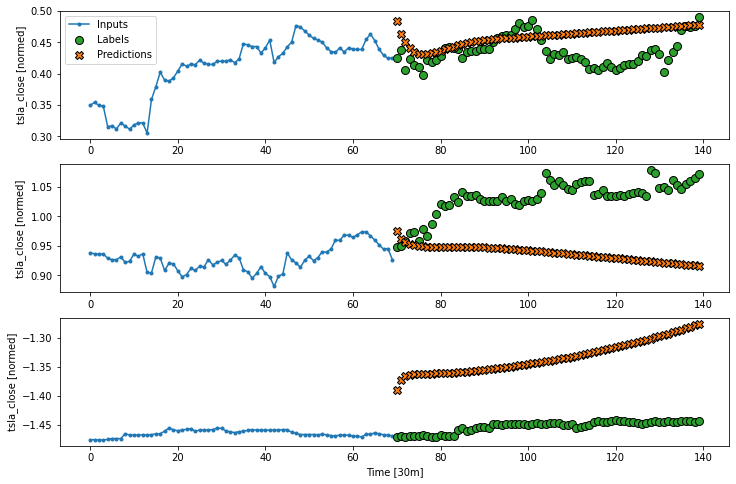

In [176]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#### Custom LSTM


427/427 [==============================] - 1s 2ms/step - loss: 0.8389 - mean_absolute_error: 0.3776


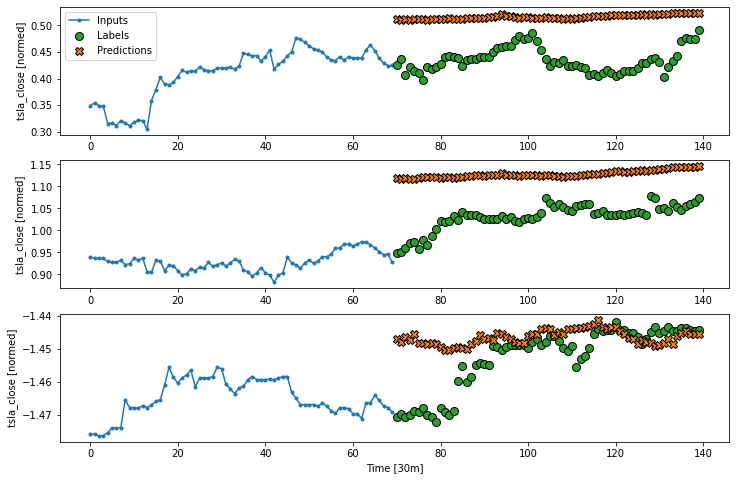

In [177]:
multi_custom_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Avg Pooling
    tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding='same'),
    # Dropout
    tf.keras.layers.Dropout(.2),
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=.6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=.6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False, dropout=.6)),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_custom_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Custom LSTM'] = multi_custom_lstm_model.evaluate(multi_window.val)
multi_performance['Custom LSTM'] = multi_custom_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_custom_lstm_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

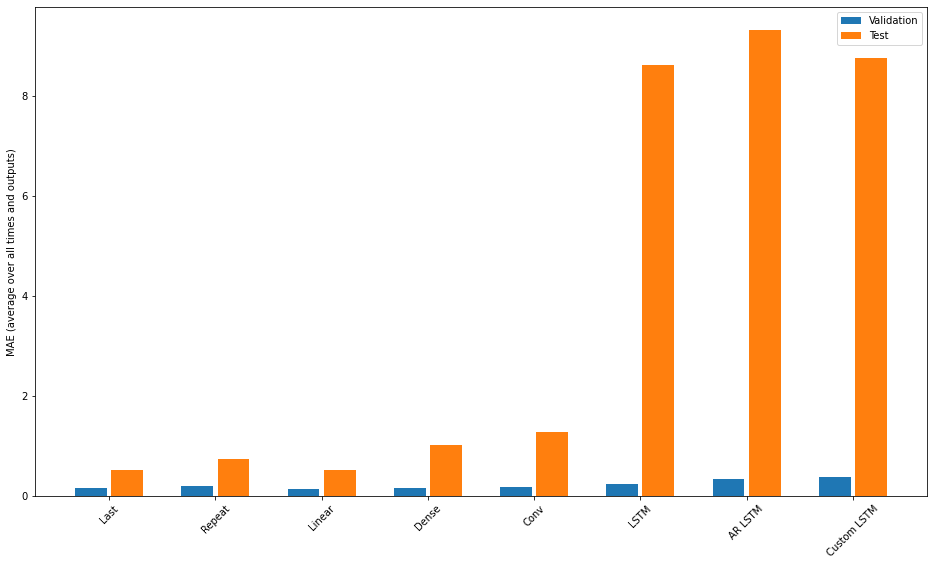

In [178]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_custom_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [179]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5163
Repeat  : 0.7491
Linear  : 0.5252
Dense   : 1.0108
Conv    : 1.2853
LSTM    : 8.6201
AR LSTM : 9.3124
Custom LSTM: 8.7564


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.